In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**This conducts a system - level energy efficiency analysis for an HVAC system. It calculates 
metrics like EUI, COP, and weather correlations. Results include EUI values compared to 
benchmarks, COP statistics, and weather - energy correlations. Visualizations such as COP 
distribution, temperature - energy, and solar radiation - energy scatter plots are generated 
to illustrate the findings.**

In [96]:
def calculate_system_efficiency(df, building_area=None):
    """
    Perform system-level energy efficiency analysis with robust COP calculation
    
    Args:
        df: Preprocessed DataFrame with columns:
            - TIMESTAMP (datetime)
            - WH_RTU_Total (Wh, cumulative)
            - AF_RTU (m3/s)
            - T_Ret_RTU (°C)
            - T_Sup_RTU (°C)
            - T_out (°C)
            - Glo_Solar (W/m2)
            - RH_out (%)
        building_area: Building area in m2 (if None, attempts auto-detection)
    
    Returns:
        Dictionary containing:
        - EUI (kWh/m2/year)
        - COP statistics
        - Weather correlations
    """
    results = {}
    
    # 1. Handle building area
    if building_area is None:
        try:
            building_info = pd.read_csv('../../HVAC/Building_Information.csv')
            building_area = float(building_info.loc[
                building_info['Data'] == 'Building_Area', 'Unit'
            ].values[0])
            print(f"Building area from file: {building_area} m2")
        except Exception as e:
            building_area = 1000  # Default 1000 m2 (~10,764 sq ft)
            # print(f"Using default area: {building_area} m2 | Error: {str(e)}")         
    
    # 2. Calculate EUI (annualized)
    total_energy_kwh = df['WH_RTU_Total'].sum() / 1000  # Convert Wh to kWh
    eui = total_energy_kwh / building_area  # kWh/m2
    
    # Compare with benchmarks from presentation (converted to kWh/m2)
    benchmarks = {
        'Hospital': (1258, 2516),    # 117-234 kWh/sq ft → 1258-2516 kWh/m2
        'Office': (161, 280),         # 15-26 kWh/sq ft → 161-280 kWh/m2
        'Retail': (161, 312)          # 15-29 kWh/sq ft → 161-312 kWh/m2
    }
    
    results['EUI'] = {
        'value': eui,
        'unit': 'kWh/m2/year',
        'benchmark': benchmarks
    }
   


    # 3. Enhanced COP Calculation
    if all(col in df.columns for col in ['AF_RTU', 'T_Ret_RTU', 'T_Sup_RTU', 'WH_RTU_Total']):
        # Calculate cooling capacity (kW)
        cooling_capacity_kw = (
            df['AF_RTU'] * 1.2 * 1.005 *  # kg/s * kJ/kg·K
            (df['T_Ret_RTU'] - df['T_Sup_RTU'])  # ΔT in K
        ) / 60  # kJ/s → kW

        # Calculate instantaneous power (kW)
        df['timedelta'] = df['TIMESTAMP'].diff().dt.total_seconds().clip(1, 3600)  # Limit 1s-1h
        df['power_kW'] = df['WH_RTU_Total'].diff() / (df['timedelta'] * 1000)

        # Validity checks
        valid_mask = (
            (df['power_kW'] > 0.1) &                      # Minimum power threshold
            (df['T_Ret_RTU'] > df['T_Sup_RTU'] + 1.0) &   # Minimum ΔT of 1°C
            (df['AF_RTU'] > 0.05) &                       # Minimum airflow
            (cooling_capacity_kw > 0)                     # Positive cooling
        )

        # Calculate COP with safeguards
        with np.errstate(divide='ignore', invalid='ignore'):
            cop = np.where(valid_mask, cooling_capacity_kw / df['power_kW'], np.nan)
        
        cop_series = pd.Series(cop).dropna()
        if len(cop_series) > 0:
            cop_stats = {
                'average': np.nanmean(cop_series.clip(0, 10)),  # Limit to realistic range
                'median': np.nanmedian(cop_series),
                'std': np.nanstd(cop_series),
                'min': np.nanmin(cop_series),
                'max': np.nanmax(cop_series),
                'valid_samples': len(cop_series),
                'valid_ratio': len(cop_series)/len(df),
                'unit': 'dimensionless'
            }
        else:
            cop_stats = {'error': 'No valid COP samples'}
    else:
        cop_stats = {'error': 'Missing required columns'}

    results['COP'] = cop_stats

    # 4. Weather correlation analysis
    weather_cols = ['WH_RTU_Total', 'T_out', 'Glo_Solar', 'RH_out']
    if all(col in df.columns for col in weather_cols):
        weather_corr = df[weather_cols].corr()
        results['weather_correlation'] = weather_corr
    else:
        results['weather_correlation'] = 'Missing weather data'


    return results

In [97]:
def plot_analysis_results(df, results):
    """Visualize the analysis results"""
    plt.figure(figsize=(18, 6))
    
    # Set font for international characters
    plt.rcParams['font.family'] = 'DejaVu Sans'  # Universally available font

    # 1. COP distribution
    plt.subplot(1, 3, 1)
    if 'COP' in results and results['COP']['valid_samples'] > 0:
        cop_vals = df['power_kW'].notna() & (df['power_kW'] > 0)
        valid_cop = df.loc[cop_vals, 'power_kW']
        sns.histplot(valid_cop, bins=30, kde=True)
        plt.title(f"COP Distribution\nMean: {results['COP']['average']:.2f}")
        plt.xlabel("Coefficient of Performance (COP)")
        plt.ylabel("Frequency")
    
    # 2. Temperature vs Energy
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='T_out', y='WH_RTU_Total', data=df, alpha=0.5)
    plt.title(f"Outdoor Temp vs Energy\nCorr: {results['weather_correlation'].loc['T_out', 'WH_RTU_Total']:.2f}")
    plt.xlabel("Outdoor Temperature (°C)")
    plt.ylabel("RTU Energy (Wh)")
    
    # 3. Solar Radiation vs Energy
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='Glo_Solar', y='WH_RTU_Total', data=df, alpha=0.5)
    plt.title(f"Solar Radiation vs Energy\nCorr: {results['weather_correlation'].loc['Glo_Solar', 'WH_RTU_Total']:.2f}")
    plt.xlabel("Solar Radiation (W/m2)")
    plt.ylabel("RTU Energy (Wh)")
    
    plt.tight_layout()
    
    plt.show()

In [98]:
def plot_temp_vs_energy(df):
    """
    Plot Outdoor Temperature vs. RTU Total Energy Consumption Scatter Plot with Key Annotations.
    
    Parameters:
        df: DataFrame containing TIMESTAMP, T_out, and WH_RTU_Total.
    """
    # Use Seaborn's recommended theme
    sns.set_theme(style="darkgrid")

    plt.figure(figsize=(10, 6))
    
    # Calculate correlation coefficient
    corr_coef = np.corrcoef(df['T_out'], df['WH_RTU_Total'])[0, 1]
    
    # Plot scatter plot with regression line
    ax = sns.regplot(
        x='T_out', 
        y='WH_RTU_Total',
        data=df,
        scatter_kws={'s': 15, 'alpha': 0.6, 'color': 'steelblue'},
        line_kws={'color': 'red', 'linestyle': '--'}
    )
    
    # Add density contour plot
    sns.kdeplot(
        x=df['T_out'],
        y=df['WH_RTU_Total'],
        levels=5,
        fill=True,  # Replace alpha
        cmap="Blues"
    )
    
    # Annotate key information
    plt.title(f"Outdoor Temperature vs. RTU Total Energy Consumption\nCorrelation Coefficient R = {corr_coef:.2f}", pad=20)
    plt.xlabel("Outdoor Temperature (°C)", labelpad=10)
    plt.ylabel("RTU Total Energy Consumption (Wh)", labelpad=10)
    
    # Add reference line
    median_temp = df['T_out'].median()
    plt.axvline(median_temp, color='gray', linestyle=':', 
               label=f'Median Temperature {median_temp:.1f}°C')
    
    # Add color-coded ranges (legend only)
    colors = {'10-20°C': 'green', '20-30°C': 'orange'}
    for label, color in colors.items():
        plt.scatter([], [], color=color, label=label)
    
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.show()


=== Results of energy efficiency analysis ===
EUI: 225.15 kWh/m2/year
Average COP: 2.07

Weather Correlation Matrix:
              WH_RTU_Total     T_out  Glo_Solar    RH_out
WH_RTU_Total      1.000000  0.258405   0.266224 -0.128211
T_out             0.258405  1.000000   0.398987  0.076852
Glo_Solar         0.266224  0.398987   1.000000 -0.466431
RH_out           -0.128211  0.076852  -0.466431  1.000000


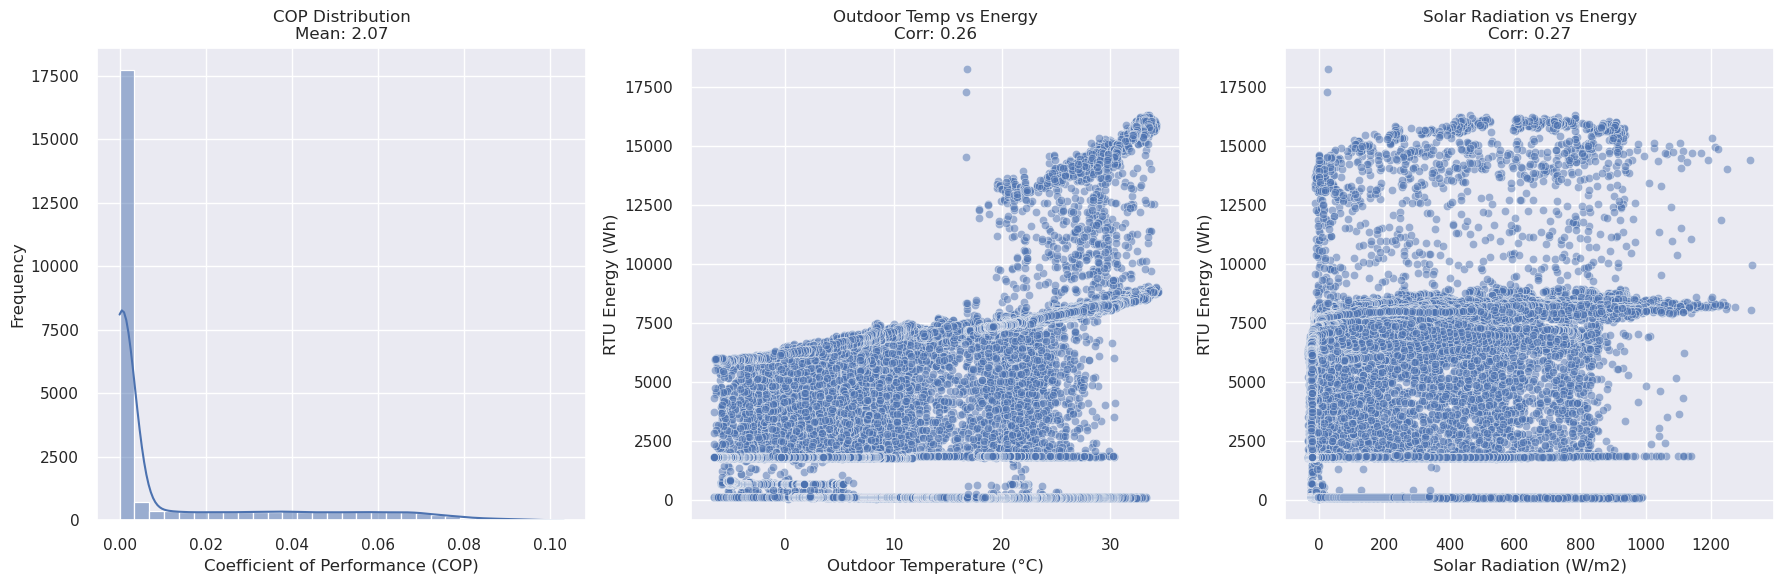

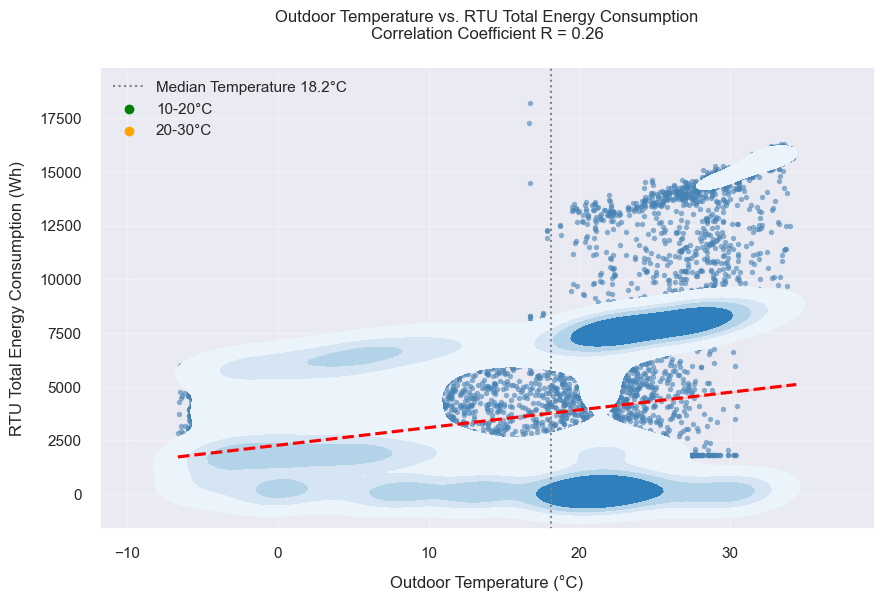

In [99]:
# Load preprocessed data
df = pd.read_csv('../../outputs/HVAC_cleaned_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    
# Perform energy efficiency analysis (can pass in actual area, e.g. building_area=15000)
results = calculate_system_efficiency(df)
    
# Print key results
print("\n=== Results of energy efficiency analysis ===")
print(f"EUI: {results['EUI']['value']:.2f} {results['EUI']['unit']}")
print(f"Average COP: {results['COP']['average']:.2f}")
print("\nWeather Correlation Matrix:")
print(results['weather_correlation'])
    
# visual analysis
plot_analysis_results(df, results)
plot_temp_vs_energy(df)